# Bonus1: Parallel Algorithms: Federated Averaging

### Name: [Yupeng Cao]
### ID: 10454637


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.04969539 -0.05248267  0.06452019  0.18436681  0.13481327  0.00568106
   0.2912809   0.04394978]]
test std = 
[[1.00456111 1.10923979 0.93503732 1.00842351 1.12855629 1.15134106
  1.26543545 1.09817632]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
"""
Some code and Function/Variable naming is refering from HW1.
"""

class Worker:
    
    def __init__(self, x, y):
        self.x = x #s-by-d
        self.y = y #s-by-1
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((d, 1)) #d-by-1
    
    # Set the model parameters to the latest
    def set_param(self, w):
        self.w = w 
        
    # Compute the local loss    
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s-by-d 
        yxw = numpy.dot(yx, self.w) #s-by-1
        vec1 = numpy.exp(-yxw) #s-by-1
        vec2 = numpy.log(1 + vec1) #s-by-1
        return numpy.sum(vec2)         
    
    # Compute local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(yxw) # s−by−1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # s−by−d matrix
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
        return g
    
    # Compute gradient descent
    def grad_descent(self, stepsize):
        g = self.gradient() 
        self.w -= stepsize * g 
        
        return self.w
    
    # Compute local gradient for SGD
    def stochastic_objective_gradient(self, w, xi, yi, lam):
        d = xi.shape[0] 
        yx = yi * xi #1-by-d
        yxw = float(numpy.dot(yx, w)) #scalar
        
        loss = numpy.log(1 + numpy.exp(-yxw)) #scalar
        reg = lam / 2 * numpy.sum(w * w)
        obj = loss + reg
        
        g_loss = -yx.T / (1 + numpy.exp(yxw)) #d-by-1
        g = g_loss + lam * w #d-by-1
        
        return obj, g
    
    # Compute local gradient descent for SGD
    def sgd(self, stepsize, lam):
        n = self.x.shape[0] 
        grads = 0
        
        #Shuffle Data Samples
        rand_indices = numpy.random.permutation(n)
        x_rand = self.x[rand_indices, :]
        y_rand = self.y[rand_indices, :]
        
        objval = 0
        for i in range(self.s):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) 
            obj, g = self.stochastic_objective_gradient(self.w, xi, yi, lam)
            objval += obj
            self.w -= stepsize * g
            grads = g
        return grads 



In [6]:
class Server:
    def __init__(self,m,n,d):
        self.m = m # work nodes
        self.n = n # training samples
        self.d = d # features
        self.w = numpy.zeros((d,1)) # d-by-1 model parameter vector
        self.g = numpy.zeros((d,1)) # d-by-1 gradient
        self.v = numpy.zeros((d,1)) # d-by-1 momentum
        self.loss = 0 #loss function value 
        self.obj = 0 #objective function value

    def broadcast(self):
        return self.w

    # Sum the grad and loss from workers
    def aggregate(self, grads, losses):
        self.g = numpy.zeros((self.d,1)) #d-by-1
        self.loss = 0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
  
      # compute the grad (from loss and regular)
    def gradient(self, lam):
        self.g = self.g / self.n + lam * self.w
  
  # compute the obj function
    def objective(self, lam):
        reg= lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss  / self.n + reg
        return self.obj

  # Update the parameters using accelerated gradient descent
  # alpha: learning rate (step size)
  # beta: momentum param
    def agd(self, alpha, bate):
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v

In [7]:
import math

def create_server_workers(m,x,y):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m,n,d)
    workers = []

    for i in range(m):
        indices = list(range(i * s, (i+1)*s))
        worker = Worker(x[indices,:],y[indices,:])
        workers.append(worker)
  
    return server, workers

In [8]:
# Initialize the hyper-parameter
lam = 1e-6
alpha = 1e-1
beta = 0.9
max_epoch = 50
stepsize = 10e-5

In [9]:
# Input:
#       q: local nterations. 

def paralle_gd(q):
    
    m = 4
    server, workers = create_server_workers(m, x_train, y_train)

    obj_values = []
    for t in range(max_epoch):
        # step 1: Broadcast w to nodes.
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

        # step 2: worker calculate gradient at local
        grads = []
        losses = []
    
        for i in range(m):
            for j in range(q):
                g = workers[i].grad_descent(stepsize)
                grads.append(g)
        
            l = workers[i].loss()
            losses.append(l)
        
        # step 3: Worker node push the gradient to server.
        server.aggregate(grads,losses)

        # step 4: server update the model parameters 
        server.gradient(lam)
        obj = server.objective(lam)
        print('obj function value',obj)
        obj_values.append(obj)
        server.agd(alpha,beta)
        
    return obj_values

In [10]:
gd_q_1 = paralle_gd(q=1)

obj function value 0.6880023332355842
obj function value 0.6801833637565399
obj function value 0.6727667403320613
obj function value 0.6657325372415559
obj function value 0.6590611164860001
obj function value 0.6527332906899934
obj function value 0.6467304477789451
obj function value 0.6410346428225113
obj function value 0.6356286621379157
obj function value 0.6304960643334936
obj function value 0.6256212024936577
obj function value 0.6209892312014843
obj function value 0.6165861015942471
obj function value 0.6123985471713356
obj function value 0.6084140626361932
obj function value 0.6046208776612731
obj function value 0.6010079271200732
obj function value 0.5975648190324265
obj function value 0.5942818012157294
obj function value 0.5911497274217882
obj function value 0.5881600235620229
obj function value 0.5853046544782822
obj function value 0.5825760915980754
obj function value 0.5799672817174941
obj function value 0.5774716170787767
obj function value 0.5750829068491015
obj function

In [11]:
gd_q_8 = paralle_gd(q=8)

obj function value 0.656930395846184
obj function value 0.6141744907979039
obj function value 0.5845776828726061
obj function value 0.5633154507545144
obj function value 0.5475209186535553
obj function value 0.535451072731736
obj function value 0.5260083179789097
obj function value 0.5184758787058282
obj function value 0.5123694968847883
obj function value 0.5073518509924883
obj function value 0.5031815169720887
obj function value 0.49968152932185894
obj function value 0.49671941944832854
obj function value 0.4941941824079519
obj function value 0.4920275469134355
obj function value 0.49015798949373734
obj function value 0.4885365416004044
obj function value 0.4871237946931894
obj function value 0.48588772248505563
obj function value 0.4848020713379411
obj function value 0.4838451527315901
obj function value 0.48299892497815067
obj function value 0.48224828620176674
obj function value 0.4815805238127719
obj function value 0.4809848814243735
obj function value 0.4804522149714353
obj func

In [12]:
def paralle_sgd(q):
    m = 4
    server, workers = create_server_workers(m, x_train, y_train)

    obj_values = []
    for t in range(max_epoch):
        # step 1 broadcast
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

        # step 2 worker local compute
        grads = []
        losses = []
    
        for i in range(m):
            for j in range(q):
                g = workers[i].sgd(stepsize, lam)
                grads.append(g)
        
            l = workers[i].loss()
            losses.append(l)
        
        # step 3: aggregate the workers' outputs
        server.aggregate(grads,losses)

        # step 4: server update the model parameters
        server.gradient(lam)
        obj = server.objective(lam)
        print('obj function value',obj)
        obj_values.append(obj)
        server.agd(alpha,beta)
    return obj_values

In [13]:
sgd_q_1 = paralle_sgd(q=1)

obj function value 0.6880194626075747
obj function value 0.6800950289197012
obj function value 0.6725141835456192
obj function value 0.6653105256858554
obj function value 0.6584410367148764
obj function value 0.6519123330288944
obj function value 0.6457257794037743
obj function value 0.6398390220264757
obj function value 0.6342368082132661
obj function value 0.6289237523832808
obj function value 0.623906682908364
obj function value 0.6191149555030145
obj function value 0.6145548468014483
obj function value 0.6101275175634363
obj function value 0.6058726519698546
obj function value 0.6017682396820533
obj function value 0.5978469959850107
obj function value 0.594062179404614
obj function value 0.5904275986006964
obj function value 0.5868973630831458
obj function value 0.5834756199532897
obj function value 0.5801496976098838
obj function value 0.5769231332359922
obj function value 0.5738159325756811
obj function value 0.5708582121558649
obj function value 0.5680492423372026
obj function v

In [14]:
sgd_q_8 = paralle_sgd(q=8)

obj function value 0.6570279582381762
obj function value 0.6142787814379711
obj function value 0.5846139560419512
obj function value 0.563212628769502
obj function value 0.5472625473343045
obj function value 0.535052125120979
obj function value 0.5254590891405173
obj function value 0.5177855098931625
obj function value 0.5115485831736413
obj function value 0.5064109032093784
obj function value 0.5021296263858864
obj function value 0.49852730724648875
obj function value 0.49546374865076237
obj function value 0.4928545554481318
obj function value 0.490613291199244
obj function value 0.4886760839240857
obj function value 0.48700021090579354
obj function value 0.48553925879461735
obj function value 0.48425600525215834
obj function value 0.4831314987983355
obj function value 0.48213711656486125
obj function value 0.4812550204786029
obj function value 0.48047076180236753
obj function value 0.479774340826582
obj function value 0.47915815324089056
obj function value 0.4786058323376663
obj func

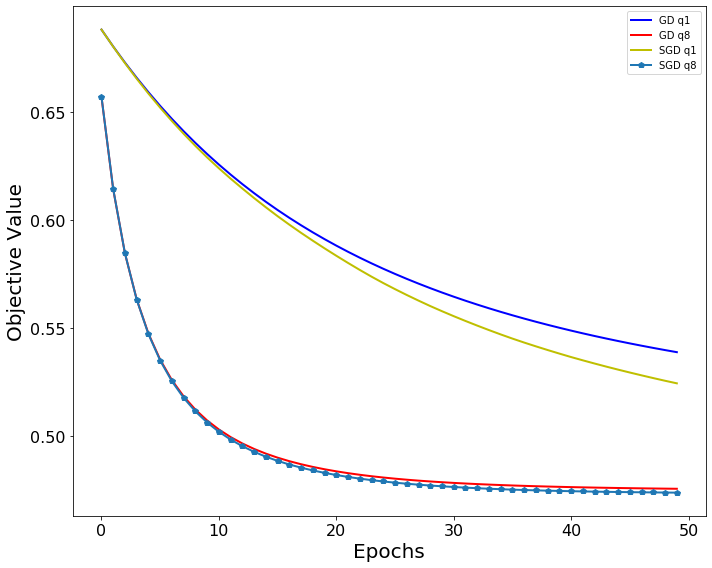

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
epochs_len = range(len(gd_q_1 ))

line0, = plt.plot(epochs_len, gd_q_1, '-b', LineWidth=2)
line1, = plt.plot(epochs_len, gd_q_8, '-r', LineWidth=2)
line2, = plt.plot(epochs_len, sgd_q_1, '-y', LineWidth=2)
line3, = plt.plot(epochs_len, sgd_q_8, '-p', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1,line2,line3], ['GD q1', 'GD q8','SGD q1','SGD q8'], fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig('compare.pdf', format='pdf')